In [1]:
%matplotlib inline
import importlib
import utils2; importlib.reload(utils2)
from utils2 import *

Using TensorFlow backend.


In [2]:
import tensorflow as tf
# Creates a graph.
a = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[2, 3], name='a')
b = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[3, 2], name='b')
c = tf.matmul(a, b)
# Creates a session with log_device_placement set to True.
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
# Runs the op.
print(sess.run(c))

[[ 22.  28.]
 [ 49.  64.]]


In [3]:
path = "camvid/"

In [4]:
images_path = path + '701_StillsRaw_full/'
labels_path = path + 'LabeledApproved_full/'

In [5]:
images = glob.glob(images_path + '*.png')
print (images[:3])

labels = [labels_path + os.path.basename(i)[:-4] + '_L.png' for i in images]
print (labels[:3])

['camvid/701_StillsRaw_full/Seq05VD_f03090.png', 'camvid/701_StillsRaw_full/0016E5_05970.png', 'camvid/701_StillsRaw_full/0006R0_f00990.png']
['camvid/LabeledApproved_full/Seq05VD_f03090_L.png', 'camvid/LabeledApproved_full/0016E5_05970_L.png', 'camvid/LabeledApproved_full/0006R0_f00990_L.png']


In [6]:
image_size = (480,360)

In [7]:
def open_image(img):
    return np.array(Image.open(img).resize(image_size, Image.NEAREST))

In [8]:
imgs = np.stack([open_image(i) for i in images])
imgs.shape

(701, 360, 480, 3)

In [9]:
lbs = np.stack([open_image(l) for l in labels])
lbs.shape

(701, 360, 480, 3)

In [10]:
imgs = imgs/255.

In [11]:
mean = imgs.mean() 
std = imgs.std()
mean, std

(0.39996644266360803, 0.30179491142291087)

In [12]:
imgs-=imgs.mean()
imgs/=imgs.std()

In [35]:
# save_array('imgs.bc', imgs)
# save_array('lbs.bc', labels)

In [13]:
class BatchIndices(object):
    def __init__(self, n, bs, shuffle=False):
        self.n,self.bs,self.shuffle = n,bs,shuffle
        self.lock = threading.Lock()
        self.reset()

    def reset(self):
        self.idxs = (np.random.permutation(self.n) 
                     if self.shuffle else np.arange(0, self.n))
        self.curr = 0

    def __next__(self):
        with self.lock:
            if self.curr >= self.n: self.reset()
            ni = min(self.bs, self.n-self.curr)
            res = self.idxs[self.curr:self.curr+ni]
            self.curr += ni
            return res

In [14]:
bi = BatchIndices(10,3, True)
[next(bi) for o in range(5)]

[array([4, 8, 2]),
 array([6, 0, 5]),
 array([3, 1, 7]),
 array([9]),
 array([4, 5, 2])]

In [15]:
class segm_generator(object):
    def __init__(self, x, y, bs=64, out_sz=(224,224), train=True):
        self.x, self.y, self.bs, self.train = x,y,bs,train
        self.n, self.ri, self.ci, _ = x.shape
        self.idx_gen = BatchIndices(self.n, bs, train)
        self.ro, self.co = out_sz
        self.ych = self.y.shape[-1] if len(y.shape)==4 else 1

    def get_slice(self, i,o):
        start = random.randint(0, i-o) if self.train else (i-o)
        return slice(start, start+o)

    def get_item(self, idx):
        slice_r = self.get_slice(self.ri, self.ro)
        slice_c = self.get_slice(self.ci, self.co)
        x = self.x[idx, slice_r, slice_c]
        y = self.y[idx, slice_r, slice_c]
        if self.train and (random.random()>0.5): 
            y = y[:,::-1]
            x = x[:,::-1]
        return x, y

    def __next__(self):
        idxs = next(self.idx_gen)
        items = (self.get_item(idx) for idx in idxs)
        xs,ys = zip(*items)
        return np.stack(xs), np.stack(ys).reshape(len(ys), -1, self.ych)

In [16]:
sg = segm_generator(imgs, lbs, 4, train=False)
b_img, b_label = next(sg)

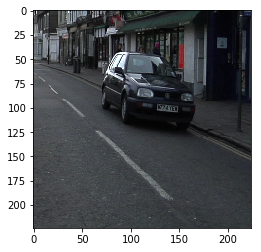

In [17]:
plt.imshow(b_img[0]*0.3+0.4);

In [18]:
def parse_code(l):
    if len(l.strip().split("\t")) == 2:
        a, b = l.strip().split("\t")
        return tuple(int(i) for i in a.split(' ')), b
    else:
        a, b, c = l.strip().split("\t")
        return tuple(int(i) for i in a.split(' ')), c

In [19]:
label_codes, label_names = zip(*[parse_code(l) for l in open(path+"label_colors.txt")])
label_codes, label_names = list(label_codes), list(label_names)
label_codes[:5], label_names[:5]

len(label_names)

32

In [20]:

label_codes, label_names

([(64, 128, 64),
  (192, 0, 128),
  (0, 128, 192),
  (0, 128, 64),
  (128, 0, 0),
  (64, 0, 128),
  (64, 0, 192),
  (192, 128, 64),
  (192, 192, 128),
  (64, 64, 128),
  (128, 0, 192),
  (192, 0, 64),
  (128, 128, 64),
  (192, 0, 192),
  (128, 64, 64),
  (64, 192, 128),
  (64, 64, 0),
  (128, 64, 128),
  (128, 128, 192),
  (0, 0, 192),
  (192, 128, 128),
  (128, 128, 128),
  (64, 128, 192),
  (0, 0, 64),
  (0, 64, 64),
  (192, 64, 128),
  (128, 128, 0),
  (192, 128, 192),
  (64, 0, 64),
  (192, 192, 0),
  (0, 0, 0),
  (64, 192, 0)],
 ['Animal',
  'Archway',
  'Bicyclist',
  'Bridge',
  'Building',
  'Car',
  'CartLuggagePram',
  'Child',
  'Column_Pole',
  'Fence',
  'LaneMkgsDriv',
  'LaneMkgsNonDriv',
  'Misc_Text',
  'MotorcycleScooter',
  'OtherMoving',
  'ParkingBlock',
  'Pedestrian',
  'Road',
  'RoadShoulder',
  'Sidewalk',
  'SignSymbol',
  'Sky',
  'SUVPickupTruck',
  'TrafficCone',
  'TrafficLight',
  'Train',
  'Tree',
  'Truck_Bus',
  'Tunnel',
  'VegetationMisc',
  'Void'

In [21]:
code2id = {v:k for k,v in enumerate(label_codes)}

id2code = {k:v for k,v in enumerate(label_codes)}

In [22]:
code2id

{(0, 0, 0): 30,
 (0, 0, 64): 23,
 (0, 0, 192): 19,
 (0, 64, 64): 24,
 (0, 128, 64): 3,
 (0, 128, 192): 2,
 (64, 0, 64): 28,
 (64, 0, 128): 5,
 (64, 0, 192): 6,
 (64, 64, 0): 16,
 (64, 64, 128): 9,
 (64, 128, 64): 0,
 (64, 128, 192): 22,
 (64, 192, 0): 31,
 (64, 192, 128): 15,
 (128, 0, 0): 4,
 (128, 0, 192): 10,
 (128, 64, 64): 14,
 (128, 64, 128): 17,
 (128, 128, 0): 26,
 (128, 128, 64): 12,
 (128, 128, 128): 21,
 (128, 128, 192): 18,
 (192, 0, 64): 11,
 (192, 0, 128): 1,
 (192, 0, 192): 13,
 (192, 64, 128): 25,
 (192, 128, 64): 7,
 (192, 128, 128): 20,
 (192, 128, 192): 27,
 (192, 192, 0): 29,
 (192, 192, 128): 8}

In [23]:
failed_code = len(label_codes)+1
failed_code

33

In [24]:
n,r,c,ch = imgs.shape
n, r, c, ch

(701, 360, 480, 3)

In [25]:
def conv_one_label(i): 
    res = np.zeros((r,c), 'uint8')
    for j in range(r): 
        for k in range(c):
            try: res[j,k] = code2id[tuple(lbs[i,j,k])]
            except: res[j,k] = failed_code
    return res

In [26]:
from concurrent.futures import ProcessPoolExecutor

In [27]:
def conv_all_labels():
    ex = ProcessPoolExecutor(8)
    return np.stack(ex.map(conv_one_label, range(n)))

In [28]:
labels_int = conv_all_labels()

In [34]:
# save_array('labels_int.bc', labels_int)

In [29]:
np.count_nonzero(labels_int==failed_code)

44

In [30]:
l = []
for i in range(len(labels_int)):
    if np.count_nonzero(labels_int[i]==failed_code) > 0:
        l.append(i)

print (len(l))

1


In [31]:
l

[193]

In [32]:
labels_int = np.delete(labels_int, l, axis=0)
len(labels_int)

700

In [33]:
labels_int.shape

(700, 360, 480)

In [34]:
np.count_nonzero(labels_int==failed_code)

0

In [35]:
imgs = np.delete(imgs, l, axis=0)
len(imgs)

700

In [36]:
def color_label(a): 
    r,c=a.shape
    res = np.zeros((r,c,3), 'uint8')
    for j in range(r): 
        for k in range(c):
            var = id2code[a[j,k]]
            res[j,k] = var
    return res

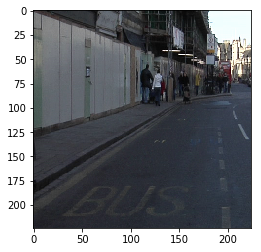

In [37]:
sg = segm_generator(imgs, lbs, 4, train=True)
b_img, b_label = next(sg)
plt.imshow(b_img[0]*0.3+0.4)

In [38]:
def dict_color_label(x):
    l = [code2id[tuple(i)] for i in x]
    l = np.array(l)
    return l

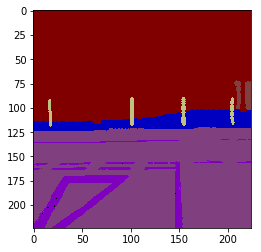

In [39]:
temp = dict_color_label(b_label[0])
plt.imshow(color_label(np.resize(temp, (224,224))))

## Creating Test Set

In [92]:
train_set = imgs[:468]
train_labels = labels_int[:468]

test_set = imgs[468:]
test_labels = labels_int[468:]

In [93]:
len(train_set), len(test_set), len(train_labels), len(test_labels)

(468, 232, 468, 232)

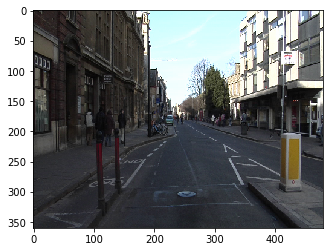

In [94]:
plt.imshow(train_set[462]*0.3+0.4)

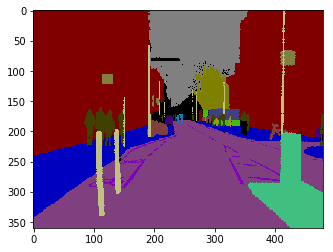

In [95]:
plt.imshow(color_label(train_labels[462]))

In [96]:
train_labels[0].shape

(360, 480)

In [97]:
train_generator = segm_generator(train_set, train_labels, 3, train=True)
test_generator = segm_generator(test_set, test_labels, 3, train=False)

In [98]:
i,la = next(train_generator)

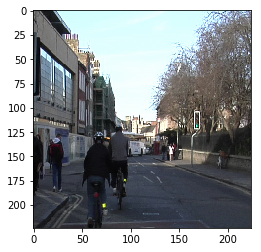

In [99]:
plt.imshow(i[0]*0.3+0.4)

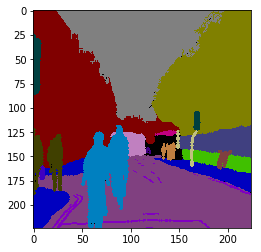

In [100]:
# t = dict_color_label(la[0])
plt.imshow(color_label(np.resize(la[0], (224,224))))

In [101]:
la[0].shape

(50176, 1)

In [40]:
def relu(x): return Activation('relu')(x)
def dropout(x, p): return Dropout(p)(x) if p else x
def bn(x): return BatchNormalization(mode=2, axis=-1)(x)
def relu_bn(x): return relu(bn(x))
def concat(xs): return merge(xs, mode='concat', concat_axis=-1)

In [41]:
def conv(x, nf, sz, wd, p, stride=1): 
    x = Convolution2D(nf, sz, sz, init='he_uniform', border_mode='same', 
                      subsample=(stride,stride), W_regularizer=l2(wd))(x)
    return dropout(x, p)

def conv_relu_bn(x, nf, sz=3, wd=0, p=0, stride=1): 
    return conv(relu_bn(x), nf, sz, wd=wd, p=p, stride=stride)

In [42]:
def dense_block(n,x,growth_rate,p,wd):
    added = []
    for i in range(n):
        b = conv_relu_bn(x, growth_rate, p=p, wd=wd)
        x = concat([x, b])
        added.append(b)
    return x,added

In [43]:
def transition_dn(x, p, wd):
#     x = conv_relu_bn(x, x.get_shape().as_list()[-1], sz=1, p=p, wd=wd)
#     return MaxPooling2D(strides=(2, 2))(x)
    return conv_relu_bn(x, x.get_shape().as_list()[-1], sz=1, p=p, wd=wd, stride=2)

In [44]:
def down_path(x, nb_layers, growth_rate, p, wd):
    skips = []
    for i,n in enumerate(nb_layers):
        x,added = dense_block(n,x,growth_rate,p,wd)
        skips.append(x)
        x = transition_dn(x, p=p, wd=wd)
    return skips, added

In [45]:
def transition_up(added, wd=0):
    x = concat(added)
    _,r,c,ch = x.get_shape().as_list()
    return Deconvolution2D(ch, 3, 3, (None,r*2,c*2,ch), init='he_uniform', 
               border_mode='same', subsample=(2,2), W_regularizer=l2(wd))(x)
#     x = UpSampling2D()(x)
#     return conv(x, ch, 2, wd, 0)

In [46]:
def up_path(added, skips, nb_layers, growth_rate, p, wd):
    for i,n in enumerate(nb_layers):
        x = transition_up(added, wd)
        x = concat([x,skips[i]])
        x,added = dense_block(n,x,growth_rate,p,wd)
    return x

In [47]:
def reverse(a): return list(reversed(a))

In [48]:
def create_tiramisu(nb_classes, img_input, nb_dense_block=6, 
    growth_rate=16, nb_filter=48, nb_layers_per_block=5, p=None, wd=0):
    
    if type(nb_layers_per_block) is list or type(nb_layers_per_block) is tuple:
        nb_layers = list(nb_layers_per_block)
    else: nb_layers = [nb_layers_per_block] * nb_dense_block

    x = conv(img_input, nb_filter, 3, wd, 0)
    skips,added = down_path(x, nb_layers, growth_rate, p, wd)
    x = up_path(added, reverse(skips[:-1]), reverse(nb_layers[:-1]), growth_rate, p, wd)
    
    x = conv(x, nb_classes, 1, wd, 0)
    _,r,c,f = x.get_shape().as_list()
    x = Reshape((-1, nb_classes))(x)
    return Activation('softmax')(x)

In [49]:
input_shape = (224,224,3)
img_input = Input(shape=input_shape)
x = create_tiramisu(32, img_input, nb_layers_per_block=[4,5,7,10,12,15], p=0.2, wd=1e-4)

In [50]:
model = Model(img_input, x)
model.compile(loss='sparse_categorical_crossentropy', 
              optimizer=keras.optimizers.RMSprop(1e-3), metrics=["accuracy"])

In [51]:
model.load_weights('test.hdf5')

In [ ]:
model.fit_generator(train_generator, len(train_set), 100, verbose=1,
                    validation_data=test_generator, nb_val_samples=len(test_set))

Epoch 1/100
468/468 [==============================] - 233s - loss: 1.9708 - acc: 0.5256 - val_loss: 2.6397 - val_acc: 0.4021
Epoch 2/100
468/468 [==============================] - 231s - loss: 1.6681 - acc: 0.5681 - val_loss: 1.8376 - val_acc: 0.6107
Epoch 3/100
468/468 [==============================] - 231s - loss: 1.5536 - acc: 0.5923 - val_loss: 1.8464 - val_acc: 0.5865
Epoch 4/100
468/468 [==============================] - 231s - loss: 1.5159 - acc: 0.5950 - val_loss: 1.7906 - val_acc: 0.5928
Epoch 5/100
468/468 [==============================] - 231s - loss: 1.3416 - acc: 0.6483 - val_loss: 1.6424 - val_acc: 0.6172
Epoch 6/100
468/468 [==============================] - 231s - loss: 1.3049 - acc: 0.6524 - val_loss: 1.7717 - val_acc: 0.5905
Epoch 7/100
468/468 [==============================] - 231s - loss: 1.2706 - acc: 0.6681 - val_loss: 1.4417 - val_acc: 0.6442
Epoch 8/100
468/468 [==============================] - 231s - loss: 1.1936 - acc: 0.6957 - val_loss: 1.4760 - val_acc:

In [69]:
model.save_weights('tiramisu_100_iterations.h5')

In [70]:
model.optimizer=keras.optimizers.RMSprop(2e-4, decay=1-0.9995)

In [ ]:
model.fit_generator(train_generator, len(train_set), 500, verbose=1,
                    validation_data=test_generator, nb_val_samples=len(test_set))

Epoch 1/500
468/468 [==============================] - 231s - loss: 0.6575 - acc: 0.8418 - val_loss: 0.8604 - val_acc: 0.7999
Epoch 2/500
468/468 [==============================] - 229s - loss: 0.6579 - acc: 0.8447 - val_loss: 0.8112 - val_acc: 0.8060
Epoch 3/500
468/468 [==============================] - 230s - loss: 0.6674 - acc: 0.8409 - val_loss: 1.2986 - val_acc: 0.6790
Epoch 4/500
468/468 [==============================] - 229s - loss: 0.6381 - acc: 0.8489 - val_loss: 0.9075 - val_acc: 0.7939
Epoch 5/500
468/468 [==============================] - 229s - loss: 0.6735 - acc: 0.8393 - val_loss: 0.9034 - val_acc: 0.7871
Epoch 6/500
468/468 [==============================] - 230s - loss: 0.6500 - acc: 0.8457 - val_loss: 0.9131 - val_acc: 0.7831
Epoch 7/500
468/468 [==============================] - 229s - loss: 0.6671 - acc: 0.8407 - val_loss: 0.7849 - val_acc: 0.8138
Epoch 8/500
468/468 [==============================] - 229s - loss: 0.6330 - acc: 0.8507 - val_loss: 0.9124 - val_acc:

KeyboardInterrupt: 

In [73]:
model.optimizer=keras.optimizers.RMSprop(2e-4, decay=1-0.9995)

In [ ]:
model.fit_generator(train_generator, len(train_set), 500, verbose=1,
                    validation_data=test_generator, nb_val_samples=len(test_set))

Epoch 1/500
468/468 [==============================] - 230s - loss: 0.6321 - acc: 0.8496 - val_loss: 0.9543 - val_acc: 0.7648
Epoch 2/500
468/468 [==============================] - 229s - loss: 0.6206 - acc: 0.8542 - val_loss: 0.9146 - val_acc: 0.7847
Epoch 3/500
468/468 [==============================] - 229s - loss: 0.6013 - acc: 0.8581 - val_loss: 0.7654 - val_acc: 0.8250
Epoch 4/500
468/468 [==============================] - 229s - loss: 0.6051 - acc: 0.8572 - val_loss: 0.7815 - val_acc: 0.8216
Epoch 5/500
468/468 [==============================] - 229s - loss: 0.6210 - acc: 0.8513 - val_loss: 0.8303 - val_acc: 0.8078
Epoch 6/500
468/468 [==============================] - 229s - loss: 0.6342 - acc: 0.8505 - val_loss: 0.8445 - val_acc: 0.7983
Epoch 7/500
468/468 [==============================] - 229s - loss: 0.6398 - acc: 0.8473 - val_loss: 0.7731 - val_acc: 0.8261
Epoch 8/500
468/468 [==============================] - 229s - loss: 0.6035 - acc: 0.8575 - val_loss: 1.1190 - val_acc:

468/468 [==============================] - 229s - loss: 0.5766 - acc: 0.8652 - val_loss: 0.6988 - val_acc: 0.8414
Epoch 148/500
468/468 [==============================] - 229s - loss: 0.5755 - acc: 0.8669 - val_loss: 0.7848 - val_acc: 0.8219
Epoch 149/500
468/468 [==============================] - 229s - loss: 0.5675 - acc: 0.8690 - val_loss: 0.8043 - val_acc: 0.8057
Epoch 150/500
468/468 [==============================] - 229s - loss: 0.5862 - acc: 0.8619 - val_loss: 0.7931 - val_acc: 0.8128
Epoch 151/500
468/468 [==============================] - 229s - loss: 0.5811 - acc: 0.8639 - val_loss: 0.7658 - val_acc: 0.8192
Epoch 152/500
468/468 [==============================] - 229s - loss: 0.5910 - acc: 0.8615 - val_loss: 0.7959 - val_acc: 0.8075
Epoch 153/500
468/468 [==============================] - 229s - loss: 0.5769 - acc: 0.8647 - val_loss: 0.7082 - val_acc: 0.8317
Epoch 154/500
468/468 [==============================] - 229s - loss: 0.5893 - acc: 0.8613 - val_loss: 0.7089 - val_ac

 15/468 [..............................] - ETA: 188s - loss: 0.4937 - acc: 0.8910

KeyboardInterrupt: 

In [76]:
model.optimizer=keras.optimizers.RMSprop(1e-5, decay=1-0.9995)

In [ ]:
model.fit_generator(train_generator, len(train_set), 500, verbose=1,
                    validation_data=test_generator, nb_val_samples=len(test_set))

Epoch 1/500
468/468 [==============================] - 230s - loss: 0.5871 - acc: 0.8628 - val_loss: 1.0621 - val_acc: 0.7402
Epoch 2/500
468/468 [==============================] - 229s - loss: 0.5751 - acc: 0.8658 - val_loss: 0.7136 - val_acc: 0.8347
Epoch 3/500
468/468 [==============================] - 229s - loss: 0.5586 - acc: 0.8717 - val_loss: 0.7256 - val_acc: 0.8298
Epoch 4/500
468/468 [==============================] - 229s - loss: 0.5595 - acc: 0.8698 - val_loss: 0.7586 - val_acc: 0.8243
Epoch 5/500
468/468 [==============================] - 229s - loss: 0.5641 - acc: 0.8699 - val_loss: 0.7290 - val_acc: 0.8405
Epoch 6/500
468/468 [==============================] - 229s - loss: 0.5491 - acc: 0.8721 - val_loss: 0.7475 - val_acc: 0.8241
Epoch 7/500
468/468 [==============================] - 229s - loss: 0.5642 - acc: 0.8701 - val_loss: 0.7349 - val_acc: 0.8290
Epoch 8/500
468/468 [==============================] - 230s - loss: 0.5610 - acc: 0.8710 - val_loss: 0.7001 - val_acc:

468/468 [==============================] - 229s - loss: 0.5687 - acc: 0.8674 - val_loss: 0.8120 - val_acc: 0.8126
Epoch 149/500
468/468 [==============================] - 229s - loss: 0.5539 - acc: 0.8728 - val_loss: 0.6821 - val_acc: 0.8393
Epoch 150/500
468/468 [==============================] - 229s - loss: 0.5485 - acc: 0.8743 - val_loss: 0.7399 - val_acc: 0.8288
Epoch 151/500
468/468 [==============================] - 229s - loss: 0.5582 - acc: 0.8719 - val_loss: 0.6857 - val_acc: 0.8431
Epoch 152/500
468/468 [==============================] - 229s - loss: 0.5451 - acc: 0.8748 - val_loss: 0.7483 - val_acc: 0.8214
Epoch 158/500
468/468 [==============================] - 229s - loss: 0.5602 - acc: 0.8701 - val_loss: 0.6820 - val_acc: 0.8404
Epoch 159/500
468/468 [==============================] - 229s - loss: 0.5754 - acc: 0.8664 - val_loss: 0.6291 - val_acc: 0.8589
Epoch 160/500
468/468 [==============================] - 229s - loss: 0.5443 - acc: 0.8739 - val_loss: 0.6456 - val_ac

KeyboardInterrupt: 

In [78]:
model.optimizer=keras.optimizers.RMSprop(1e-3, decay=1-0.99995)

In [ ]:
model.fit_generator(train_generator, len(train_set), 50, verbose=1,
                    validation_data=test_generator, nb_val_samples=len(test_set))

Epoch 1/50
468/468 [==============================] - 230s - loss: 0.5642 - acc: 0.8685 - val_loss: 0.6822 - val_acc: 0.8428
Epoch 2/50
468/468 [==============================] - 229s - loss: 0.5579 - acc: 0.8707 - val_loss: 0.6990 - val_acc: 0.8443
Epoch 3/50
468/468 [==============================] - 229s - loss: 0.5475 - acc: 0.8748 - val_loss: 0.6737 - val_acc: 0.8461
Epoch 4/50
468/468 [==============================] - 229s - loss: 0.5603 - acc: 0.8704 - val_loss: 0.8084 - val_acc: 0.8189
Epoch 5/50
468/468 [==============================] - 229s - loss: 0.5609 - acc: 0.8717 - val_loss: 0.6900 - val_acc: 0.8419
Epoch 6/50
468/468 [==============================] - 229s - loss: 0.5450 - acc: 0.8760 - val_loss: 0.7996 - val_acc: 0.8083
Epoch 7/50
468/468 [==============================] - 229s - loss: 0.5534 - acc: 0.8727 - val_loss: 0.7407 - val_acc: 0.8306
Epoch 9/50
468/468 [==============================] - 229s - loss: 0.5559 - acc: 0.8727 - val_loss: 0.7126 - val_acc: 0.8376


In [80]:
model.save_weights('test.hdf5')

In [138]:
model.load_weights('tiramisu_100_iterations.h5')

In [ ]:
predictions = model.predict_generator(test_generator, len(test_set))

In [136]:
predictions.shape

In [131]:
target=test_labels[:,8:]

(232, 50168, 32)

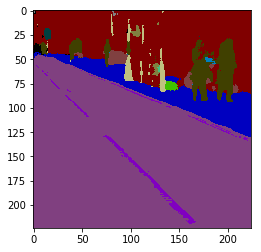

In [94]:
plt.imshow(color_label(np.resize(predictions[3], (224,224))))

In [1]:
plt.imshow(test_labels[1])

NameError: name 'plt' is not defined

In [103]:
j, t_la = next(test_generator)

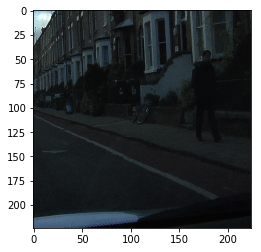

In [104]:
plt.imshow(j[0]*0.3+0.4)

In [59]:
try_image = np.array(Image.open('Seq05VD_f05100.png').resize((224,224), Image.NEAREST))
try_image = try_image/255.
try_image-=mean
try_image/=std
try_image.shape

(224, 224, 3)

In [60]:
try_preds = model.predict(np.expand_dims(try_image, 0), 1)

In [61]:
try_preds = np.argmax(try_preds, axis=-1)
try_preds.shape

(1, 50176)

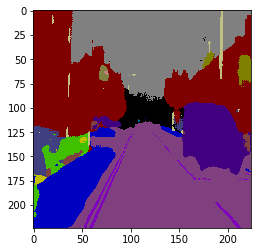

In [62]:
plt.imshow(color_label(np.resize(try_preds[0], (224,224))))
plt.imsave()

In [63]:
image_size

(480, 360)

In [52]:
try_img = np.array(Image.open('Seq05VD_f05100.png').resize(image_size, Image.NEAREST))
try_img = try_img/255.
try_img-=mean
try_img/=std

In [53]:
try_label = np.array(Image.open('Seq05VD_f05100_L.png').resize(image_size, Image.NEAREST))

In [54]:
try_gen = segm_generator(np.expand_dims(try_img, 0), np.expand_dims(try_img, 0), 1, train=False)

In [55]:
prd = model.predict_generator(try_gen, 1)

In [56]:
prd = np.argmax(prd, axis=-1)

In [57]:
prd.shape

(1, 50176)

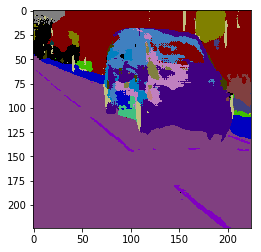

In [58]:
plt.imshow(color_label(np.resize(prd[0], (224,224))))